In [2]:
import numpy as np
import numpy.ma as ma
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy
import sunpy.map
import rht
from rht.convRHT import convRHT
from rht import RHT_tools
from glob import glob
import h5py
import matplotlib.pyplot as plt
from sun_blinker import ImageBlinker
from scipy.integrate import simps
from watroo import wow
from skimage import filters
import cmcrameri.cm as cmcm
import sunkit_image.trace as trace

In [3]:
hri_maps_1024 = sorted(glob('../../src/EUI/HRI/euv174/20221024/coalign_step_boxcar/*.fits'))

In [4]:
hri_map_1024_example = sunpy.map.Map(hri_maps_1024[181])
# trace_map = fits.getdata('~/Downloads/TRACE_19980519.fits').astype(np.float64)
# trace_map = fits.getdata('~/scripts/RHT/testdata/testim_tesla_small.fits')

In [5]:
sample_data = wow(hri_map_1024_example.data[600:760,500:670], denoise_coefficients=[5,3])[0]
# sample_data = wow(trace_map[200:-200,200:-200], denoise_coefficients=[5,3])[0]
# sample_data = trace_map

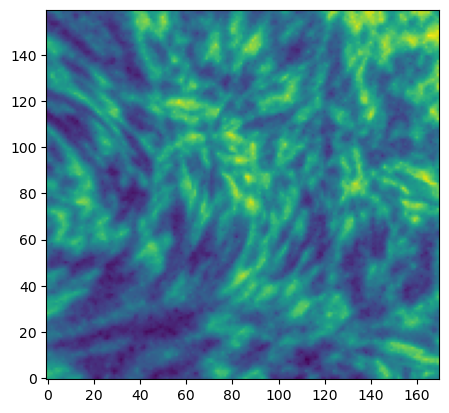

In [6]:
plt.imshow(sample_data, origin='lower')

In [7]:
sample_data_filter = filters.meijering(sample_data, sigmas=[0.2,],alpha=1.5)

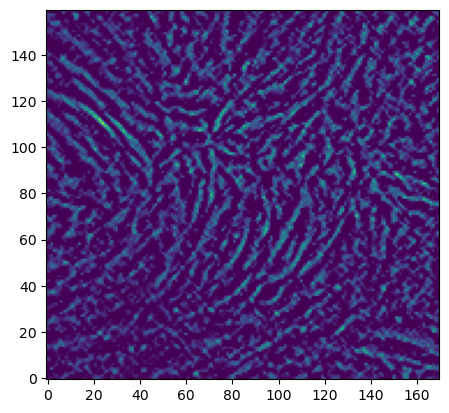

In [8]:
plt.imshow(sample_data_filter, origin='lower')

In [9]:
def make_segmentation(data, threshold):
    return data > threshold

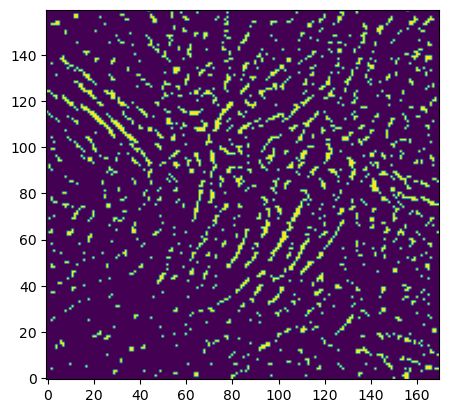

In [10]:
plt.imshow(make_segmentation(sample_data_filter, 0.3), origin='lower')

In [11]:
rht_cube_hri_1024_example = convRHT(make_segmentation(sample_data_filter, 0.3), wlen=7, smr=2, thresh=0.,
        save=False,)

In [12]:
thets_arr = RHT_tools.get_thets(wlen=7, save=False)

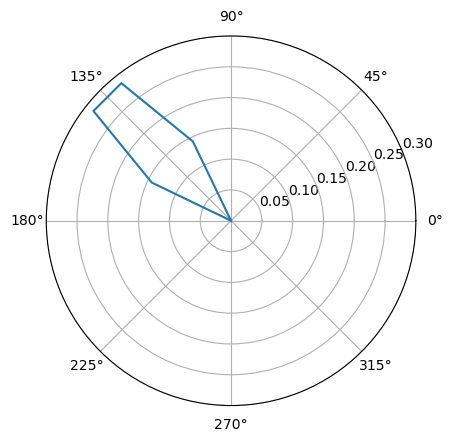

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(thets_arr, rht_cube_hri_1024_example[120,25,:])

In [14]:
def calc_params_rht(rht_cube, thets_arr, threshold=0.25, u_alpha=1.96):
    rht_cube_filter = rht_cube.copy()
    rht_cube_filter[rht_cube_filter < np.nanmax(rht_cube_filter, axis=2)[:,:,np.newaxis] - threshold] = 0
    c_bar = np.nansum(rht_cube_filter*np.cos(2*thets_arr), axis=2)/np.nansum(rht_cube_filter, axis=2)
    s_bar = np.nansum(rht_cube_filter*np.sin(2*thets_arr), axis=2)/np.nansum(rht_cube_filter, axis=2)

    theta_bar = np.zeros_like(c_bar)*np.nan
    theta_bar[c_bar >= 0] = 0.5*np.arctan(s_bar[c_bar >= 0]/c_bar[c_bar >= 0])
    theta_bar[c_bar < 0] = 0.5*np.arctan(s_bar[c_bar < 0]/c_bar[c_bar < 0]) + np.pi/2

    R_bar = np.sqrt(c_bar**2 + s_bar**2)
    circular_std = np.sqrt(-2*np.log(R_bar))

    alpha_hat = np.nansum(rht_cube_filter*np.cos(2*(thets_arr-theta_bar[:,:,np.newaxis])), axis=2)/np.nansum(rht_cube_filter, axis=2)
    epsilon_theta = np.arcsin(u_alpha*np.sqrt((1 - alpha_hat)/(2*np.nansum(rht_cube_filter>0, axis=2)*R_bar**2)))

    return rht_cube_filter, theta_bar, R_bar, epsilon_theta


In [15]:
rht_cube_filter, theta_bar, R_bar, epsilon_theta = calc_params_rht(rht_cube_hri_1024_example, thets_arr, threshold=0.25, u_alpha=1.96)

/tmp/ipykernel_678403/3641848254.py:4: RuntimeWarning: invalid value encountered in divide
  c_bar = np.nansum(rht_cube_filter*np.cos(2*thets_arr), axis=2)/np.nansum(rht_cube_filter, axis=2)
/tmp/ipykernel_678403/3641848254.py:5: RuntimeWarning: invalid value encountered in divide
  s_bar = np.nansum(rht_cube_filter*np.sin(2*thets_arr), axis=2)/np.nansum(rht_cube_filter, axis=2)
/tmp/ipykernel_678403/3641848254.py:8: RuntimeWarning: divide by zero encountered in divide
  theta_bar[c_bar >= 0] = 0.5*np.arctan(s_bar[c_bar >= 0]/c_bar[c_bar >= 0])
/tmp/ipykernel_678403/3641848254.py:8: RuntimeWarning: invalid value encountered in divide
  theta_bar[c_bar >= 0] = 0.5*np.arctan(s_bar[c_bar >= 0]/c_bar[c_bar >= 0])
/tmp/ipykernel_678403/3641848254.py:12: RuntimeWarning: divide by zero encountered in log
  circular_std = np.sqrt(-2*np.log(R_bar))
/tmp/ipykernel_678403/3641848254.py:14: RuntimeWarning: invalid value encountered in divide
  alpha_hat = np.nansum(rht_cube_filter*np.cos(2*(thets_

In [16]:
rht_mask = R_bar < 0.5
theta_bar_masked = ma.masked_array(theta_bar, mask=rht_mask)
R_bar_masked = ma.masked_array(R_bar, mask=rht_mask)

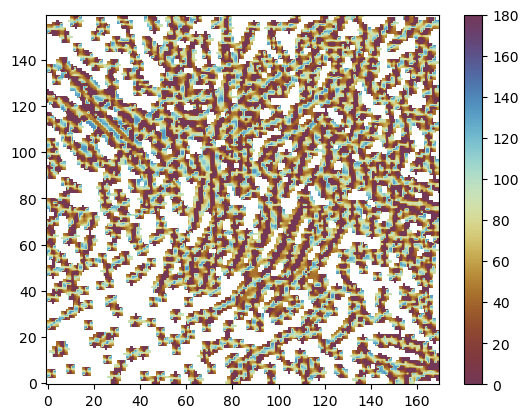

In [17]:
plt.imshow(np.rad2deg(theta_bar), vmin=0, vmax=180, origin='lower',
           cmap=cmcm.romaO)
plt.colorbar()

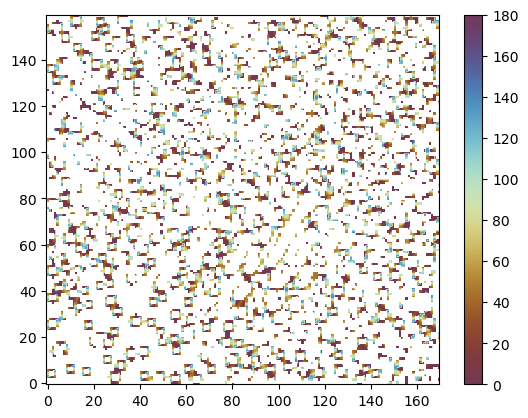

In [18]:
plt.imshow(np.rad2deg(theta_bar_masked), vmin=0, vmax=180, origin='lower',
           cmap=cmcm.romaO)
plt.colorbar()

In [19]:
test_image = np.zeros((100,100))
for ii in range(0, 80):
    test_image[ii,100-ii+10-1:100-ii+10+1] = 1
test_image_rht_cube = convRHT(test_image, wlen=11, smr=2, thresh=0.7,
        save=False,)

test_theta_array = RHT_tools.get_thets(wlen=11, save=False)

In [20]:
test_rht_cube_filter, test_theta_bar, test_R_bar, test_epsilon_theta = calc_params_rht(test_image_rht_cube, 
                                                                                       test_theta_array, threshold=0.7, u_alpha=1.96)

/tmp/ipykernel_678403/3641848254.py:4: RuntimeWarning: invalid value encountered in divide
  c_bar = np.nansum(rht_cube_filter*np.cos(2*thets_arr), axis=2)/np.nansum(rht_cube_filter, axis=2)
/tmp/ipykernel_678403/3641848254.py:5: RuntimeWarning: invalid value encountered in divide
  s_bar = np.nansum(rht_cube_filter*np.sin(2*thets_arr), axis=2)/np.nansum(rht_cube_filter, axis=2)
/tmp/ipykernel_678403/3641848254.py:14: RuntimeWarning: invalid value encountered in divide
  alpha_hat = np.nansum(rht_cube_filter*np.cos(2*(thets_arr-theta_bar[:,:,np.newaxis])), axis=2)/np.nansum(rht_cube_filter, axis=2)


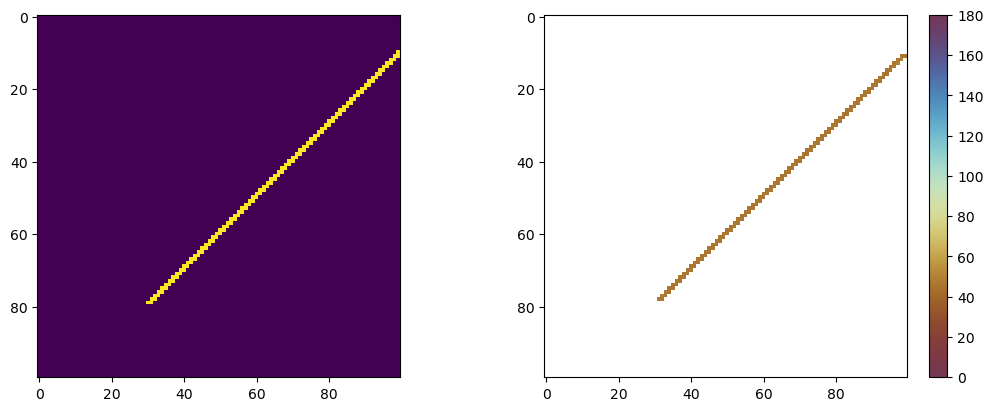

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4),layout='constrained')
ax1.imshow(test_image)
im2 = ax2.imshow(np.rad2deg(test_theta_bar), vmin=0, vmax=180, cmap=cmcm.romaO)
plt.colorbar(im2)

In [22]:
occult2_trace = trace.occult2(sample_data, nsm1=3, rmin=15, lmin=5, nstruc=500, ngap=1, qthresh1=0, qthresh2=3)

In [28]:
np.array(occult2_trace[0]).shape

(23, 2)

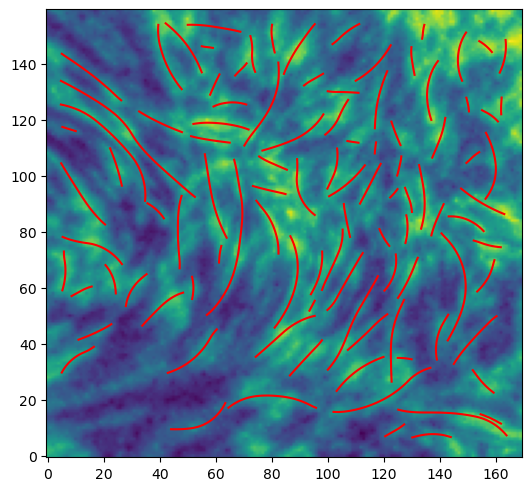

In [30]:
fig, ax = plt.subplots(layout='constrained')
ax.imshow(sample_data, origin='lower')
for trace_ in occult2_trace:
    trace_ = np.array(trace_)
    ax.plot(trace_[:,0],trace_[:,1],color='r')